# Importing the modules 

In [1]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import IPython

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


# Data Import and Preprocessing

In [8]:
!wget -O hirise-map-proj-v3_2.zip https://zenodo.org/record/4002935/files/hirise-map-proj-v3_2.zip?download=1

--2022-11-01 10:10:17--  https://zenodo.org/record/4002935/files/hirise-map-proj-v3_2.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 911235740 (869M) [application/octet-stream]
Saving to: ‘hirise-map-proj-v3_2.zip’

hirise-map-proj-v3_ 100%[===================>] 869.02M   105MB/s    in 9.5s    

2022-11-01 10:10:27 (91.6 MB/s) - ‘hirise-map-proj-v3_2.zip’ saved [911235740/911235740]



In [9]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
 !unzip hirise-map-proj-v3_2.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: hirise-map-proj-v3_2/map-proj-v3_2/ESP_016781_2055_RED-0008-r270.jpg  
  inflating: __MACOSX/hirise-map-proj-v3_2/map-proj-v3_2/._ESP_016781_2055_RED-0008-r270.jpg  
  inflating: hirise-map-proj-v3_2/map-proj-v3_2/PSP_001481_1875_RED-0012-r90.jpg  
  inflating: __MACOSX/hirise-map-proj-v3_2/map-proj-v3_2/._PSP_001481_1875_RED-0012-r90.jpg  
  inflating: hirise-map-proj-v3_2/map-proj-v3_2/ESP_036804_2345_RED-0528-fv.jpg  
  inflating: __MACOSX/hirise-map-proj-v3_2/map-proj-v3_2/._ESP_036804_2345_RED-0528-fv.jpg  
  inflating: hirise-map-proj-v3_2/map-proj-v3_2/ESP_049651_1050_RED-0043-fv.jpg  
  inflating: __MACOSX/hirise-map-proj-v3_2/map-proj-v3_2/._ESP_049651_1050_RED-0043-fv.jpg  
  inflating: hirise-map-proj-v3_2/map-proj-v3_2/ESP_026511_2330_RED-0067-r90.jpg  
  inflating: __MACOSX/hirise-map-proj-v3_2/map-proj-v3_2/._ESP_026511_2330_RED-0067-r90.jpg  
  inflating: hirise-map-proj-v3_2/map-p

In [11]:
!mkdir hirise-map-proj-v3_2

mkdir: cannot create directory ‘hirise-map-proj-v3_2’: File exists


In [12]:
'''import pathlib
import os
dataset_folder = 'hirise-map-proj-v3_2'
DatasetFiles = list(pathlib.Path(os.path.join(dataset_folder)).glob("*.*"))''';

# Preprocessing

In [3]:
path = '/content/hirise-map-proj-v3_2/'

In [18]:
'''class_map = {0: 'other',
             1: 'crater',
             2: 'dark_dune',
             3: 'streak',
             4: 'bright_dune',
             5: 'impact',
             6: 'edge',
             7: 'spider'}''';

class_map = {0: 'crater',
             1: 'dark_dune',
             2: 'streak',
             3: 'bright_dune',
             4: 'impact',
             5: 'edge',
             6: 'spider'}

In [19]:
file = open(path + 'labels-map-proj_v3_2.txt', 'r')
lines = [line.strip() for line in file.readlines()]
lines = lines[:15000] # Memory issues
file.close()

train, not_train = train_test_split(lines, train_size=0.7)
val, test = train_test_split(not_train, test_size=0.5)

In [20]:
img_path = path + 'map-proj-v3_2/'
print(img_path)
def get_set(lines_):
    images = []
    labels = []

    for line in tqdm(lines_):
      
        
        filename, label = line.split(' ')
        
        if(int(label) !=0):
          img = np.array(Image.open(img_path + filename))
          #img = img/255
          
          images.append(img)
          labels.append(int(label)-1)

    images = np.array(images)
    labels = np.array(labels)

    

    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_smote, y_smote = sm.fit_resample(images.reshape((images.shape[0],images.shape[1]*images.shape[2])), labels)
    X_smote=X_smote.reshape((X_smote.shape[0],227,227))
    print(X_smote.shape)
    return X_smote, y_smote


print("Importing training set...")
train_images, train_labels = get_set(train)
del train
print()
print("Importing validation set...")
val_images, val_labels = get_set(val)
del val
print()
print("Importing test set...")
test_images, test_labels = get_set(test)
del test

/content/hirise-map-proj-v3_2/map-proj-v3_2/
Importing training set...


100%|██████████| 10500/10500 [00:01<00:00, 5518.09it/s]


(7035, 227, 227)

Importing validation set...


100%|██████████| 2250/2250 [00:00<00:00, 3401.59it/s]


(1652, 227, 227)

Importing test set...


100%|██████████| 2250/2250 [00:00<00:00, 5389.43it/s]


(1631, 227, 227)


In [21]:
classes, counts = np.unique(train_labels, return_counts=True)
classes, counts

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1005, 1005, 1005, 1005, 1005, 1005, 1005]))

In [22]:
print(train_images.min(), train_images.max())

0 255


In [23]:
train_images = train_images/255
val_images = val_images/255
test_images = test_images/255

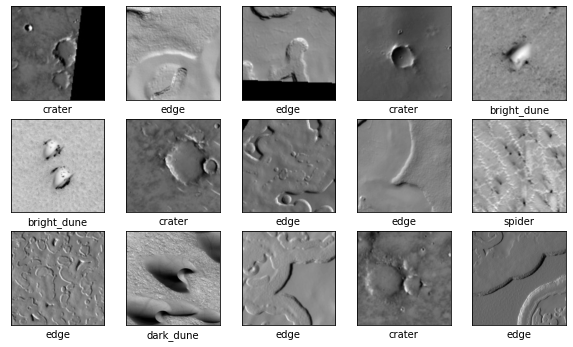

In [24]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary_r)
    plt.xlabel(class_map[train_labels[i]])
plt.show()

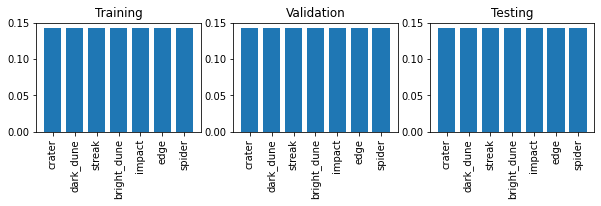

In [25]:
def plot_class_dist(labels, title):
  classes, counts = np.unique(labels, return_counts=True)
  classes = [class_map[label] for label in classes]
  normalized_counts = (counts/counts.sum())
  plt.bar(classes, normalized_counts)
  plt.title(title)
  plt.xticks(rotation=90)


plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plot_class_dist(train_labels, 'Training')
plt.subplot(1,3,2)
plot_class_dist(val_labels, 'Validation')
plt.subplot(1,3,3)
plot_class_dist(test_labels, 'Testing')
plt.show()

In [26]:
print(train_images.shape, val_images.shape, test_images.shape)


(7035, 227, 227) (1652, 227, 227) (1631, 227, 227)


In [27]:
train_images = train_images.reshape((train_images.shape[0],227,227,1))
val_images = val_images.reshape((val_images.shape[0],227,227,1))
test_images = test_images.reshape((test_images.shape[0],227,227,1))

print(train_images.shape, val_images.shape, test_images.shape)

(7035, 227, 227, 1) (1652, 227, 227, 1) (1631, 227, 227, 1)


# Modeling

In [28]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
session.as_default()


In [29]:

BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 5e-3
MAX_LR = 1e-3
Lr = 1e-3

In [30]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x = x_set # camera vector
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return batch_x, batch_y

In [31]:
train_gen = DataGenerator(train_images, train_labels, BATCH_SIZE)
val_gen   = DataGenerator(val_images, val_labels,   BATCH_SIZE)
test_gen  = DataGenerator(test_images, test_labels,  BATCH_SIZE)

In [32]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

In [33]:
image_size = 227

In [34]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model= tf.keras.layers.Dropout(0.8)(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.8)(model)
model = tf.keras.layers.Dense(7,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

16705208/16705208 [==============================] - 0s 0us/step


In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, mode='auto'),
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_accuracy', mode = 'max', restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("/content/bestmodel.hdf5", monitor='val_accuracy', save_best_only=True,mode='max', save_freq='epoch')]
                             


In [36]:
import tensorflow.keras.backend as KB

with session.as_default():
  KB.clear_session()
  model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
history_all = {}
with session.as_default():
  history = model.fit(train_gen, validation_data=val_gen, epochs =30,verbose=1, batch_size=BATCH_SIZE,callbacks=callbacks)
  


Epoch 1/30
220/220 [==============================] - 95s 353ms/step - loss: 1.3437 - accuracy: 0.5066 - val_loss: 6.2173 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 2/30
220/220 [==============================] - 76s 347ms/step - loss: 0.7930 - accuracy: 0.7080 - val_loss: 4.4363 - val_accuracy: 0.1477 - lr: 0.0010
Epoch 3/30
220/220 [==============================] - 76s 346ms/step - loss: 0.5188 - accuracy: 0.8226 - val_loss: 2.1230 - val_accuracy: 0.1289 - lr: 0.0010
Epoch 4/30
220/220 [==============================] - 76s 347ms/step - loss: 0.4477 - accuracy: 0.8486 - val_loss: 2.2203 - val_accuracy: 0.1441 - lr: 0.0010
Epoch 5/30
220/220 [==============================] - 77s 352ms/step - loss: 0.1377 - accuracy: 0.9647 - val_loss: 2.6162 - val_accuracy: 0.2131 - lr: 3.0000e-04
Epoch 6/30
220/220 [==============================] - 77s 351ms/step - loss: 0.0717 - accuracy: 0.9811 - val_loss: 1.6778 - val_accuracy: 0.4594 - lr: 3.0000e-04
Epoch 7/30
220/220 [========================

In [37]:
model.load_weights("/content/bestmodel.hdf5")

### Evaluating the model

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


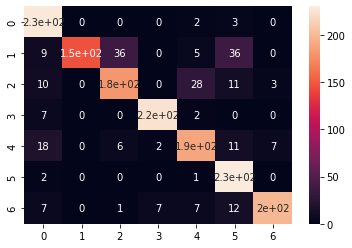

In [42]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    pred,
), annot=True)

In [44]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(test_labels,pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       233
           1       1.00      0.63      0.77       233
           2       0.81      0.78      0.79       233
           3       0.96      0.96      0.96       233
           4       0.81      0.81      0.81       233
           5       0.76      0.99      0.86       233
           6       0.95      0.85      0.90       233

    accuracy                           0.86      1631
   macro avg       0.87      0.86      0.85      1631
weighted avg       0.87      0.86      0.85      1631



In [45]:
from sklearn.metrics import f1_score
f1_score(test_labels, pred, average='macro')

0.8546318511292602

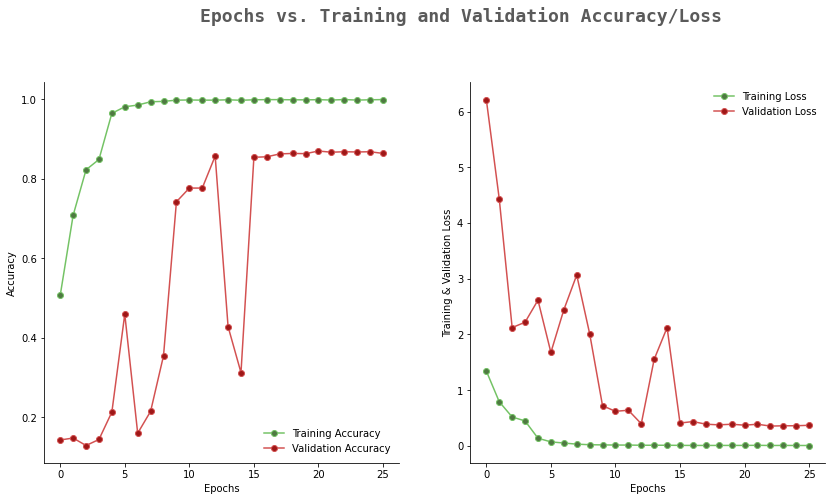

In [46]:
from warnings import filterwarnings

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

filterwarnings('ignore')

epochs = [i for i in range(len(history.history['loss']))]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()


ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()

ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()
